<a href="https://colab.research.google.com/github/claude9493/DSAA5002/blob/main/notebook/BetaRec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/claude9493/dsaa5002.git
!mv ./dsaa5002/dataset/ ./
!mv ./dsaa5002/utils/ ./

!pip install geomloss

Cloning into 'dsaa5002'...
remote: Enumerating objects: 100, done.
remote: Counting objects: 100% (100/100), done.
remote: Compressing objects: 100% (92/92), done.
remote: Total 100 (delta 29), reused 9 (delta 3), pack-reused 0
Receiving objects: 100% (100/100), 9.67 MiB | 14.88 MiB/s, done.
Resolving deltas: 100% (29/29), done.


In [2]:
%%time

from utils.utils import create_dataset, Trainer
# from layer.layer import Embedding, FeaturesEmbedding, EmbeddingsInteraction, MultiLayerPerceptron

import math
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import TensorDataset, DataLoader

from geomloss import SamplesLoss

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Training on [{}].'.format(device))

Training on [cuda:0].
CPU times: user 1.18 s, sys: 784 ms, total: 1.96 s
Wall time: 6.14 s


In [3]:
%%time
SAMPLE_NUM = 10000
task = 'regression'  # 'classification'
dataset = create_dataset('movielens', sample_num=SAMPLE_NUM, task=task, device=device)
field_dims, (train_X, train_y), (valid_X, valid_y), (test_X, test_y) = dataset.train_valid_test_split()

CPU times: user 1.97 s, sys: 1.1 s, total: 3.07 s
Wall time: 16.5 s


In [13]:
class SingledirectionalOneShotIterator(object):
    def __init__(self, dataloader):
        self.iterator = self.one_shot_iterator(dataloader)
        self.step = 0
        
    def __next__(self):
        self.step += 1
        data = next(self.iterator)
        return data
    
    @staticmethod
    def one_shot_iterator(dataloader):
        while True:
            for data in dataloader:
                yield data

class Beta_Loss:
    def __init__(self, model, reg_biase=0.005, reg_lambda=0.005):
        self.reg_biase = reg_biase
        self.reg_lambda = reg_lambda
        self.model = model

    def __call__(self, pred, target):
        loss = (1-self.reg_biase) * torch.sqrt(nn.MSELoss()(pred.view(-1,1), target))
        loss += self.reg_biase * self.model.loss[0]
        # loss += self.reg_lambda * self.model.loss[1]
        # loss = nn.MSELoss(reduction='sum')(pred.view(-1,1), target)
        loss = torch.nan_to_num(loss)
        return torch.sqrt(loss)

class Regularizer():
    def __init__(self, base_add, min_val, max_val):
        self.base_add = base_add
        self.min_val = min_val
        self.max_val = max_val

    def __call__(self, entity_embedding):
        return torch.clamp(entity_embedding + self.base_add, self.min_val, self.max_val)

In [14]:
class BetaRecommendation(nn.Module):

    def __init__(self, field_dims, embed_dim=4, **kwargs):
        super(BetaRecommendation, self).__init__()
        n_users, n_movies = field_dims[0], field_dims[1]

        self.gamma = nn.Parameter(
            torch.Tensor([kwargs.get('gamma', 12)]), 
            requires_grad=False)
        self.lb = kwargs.get('lb', 1)
        self.ub = kwargs.get('ub', 100)

        self.Bu = nn.Parameter(torch.randn(n_users), requires_grad=True)
        self.Bm = nn.Parameter(torch.randn(n_movies), requires_grad=True)

        self.u = nn.Embedding(n_users, embed_dim * 2)
        # self.u = nn.Parameter(torch.zeros(n_users, embed_dim * 2))
        self.m = nn.Embedding(n_movies, embed_dim * 2)
        # self.m = nn.Parameter(torch.zeros(n_movies, embed_dim * 2))
        
        self.u.weight.data.uniform_(self.lb, self.ub)
        self.m.weight.data.uniform_(self.lb, self.ub)
        
        self.regularizer = Regularizer(1, self.lb, self.ub)
        self.loss = [0,0]

        self.sample_loss = SamplesLoss(loss="sinkhorn", scaling=1e-1000)

        
    def forward(self, x, global_mean=0):
      # Predict rating
        users, movies = x[:,0], x[:,1]
        u, m = self.u(users), self.m(movies)
        Bu, Bm = self.Bu[users], self.Bm[movies]
        u[torch.isnan(u)] = 0.05
        m[torch.isnan(m)] = 0.05

        alpha_u, beta_u = torch.chunk(self.regularizer(u).unsqueeze(-1), 2, dim=1)
        alpha_m, beta_m = torch.chunk(self.regularizer(m).unsqueeze(-1), 2, dim=1)

        u_dist = torch.distributions.beta.Beta(alpha_u, beta_u)
        m_dist = torch.distributions.beta.Beta(alpha_m, beta_m)

        distance = self.KL_distance(u_dist, m_dist)
        # distance = self.Wasserstein_distance(u_dist, m_dist)
    
        output = Bu + Bm - distance
        
        self.loss[0] = torch.norm(Bu) + torch.norm(Bm)
        return output
      
    def KL_distance(self, u_dist, m_dist):
      # return torch.norm(torch.distributions.kl.kl_divergence(u_dist, m_dist), p=1, dim=-1)
      
      # print([u_dist, m_dist, 
            #  torch.norm(torch.nan_to_num(torch.log(torch.distributions.kl.kl_divergence(u_dist, m_dist)), 
                                        #  nan=1.0, posinf=1.0), p=1, dim=-1)])

      # return -torch.nan_to_num(self.gamma - torch.norm(torch.nan_to_num(torch.distributions.kl.kl_divergence(u_dist, m_dist).squeeze(), 
      #                                                                  nan=1, posinf=1), p=1, dim=-1))
      return torch.norm(2.0/torch.pi * torch.atan(torch.distributions.kl.kl_divergence(u_dist, m_dist).squeeze()), p=1, dim=-1)

    def Wasserstein_distance(self, u_dist, m_dist):
      # Generate reference points
      x = torch.linspace(0.001, 0.999, 16).view(1, -1)
      u_ref = torch.exp(u_dist.log_prob(x))
      m_ref = torch.exp(m_dist.log_prob(x))
      return self.sample_loss.forward(u_ref, m_ref)

In [6]:
# alpha, beta = torch.chunk(torch.tensor([1,2,3,4,5,6]).repeat(2), 2, dim=-1)
alpha = torch.randint(low=1, high=20, size=(64, 16)).unsqueeze(-1)
beta = torch.randint(low=1, high=20, size=(64, 16)).unsqueeze(-1)

dist_1 = torch.distributions.beta.Beta(torch.randint(low=1, high=20, size=(64, 16)).unsqueeze(-1), 
                                       torch.randint(low=1, high=20, size=(64, 16)).unsqueeze(-1))
dist_2 = torch.distributions.beta.Beta(torch.randint(low=1, high=20, size=(64, 16)).unsqueeze(-1), 
                                       torch.randint(low=1, high=20, size=(64, 16)).unsqueeze(-1))
x = torch.linspace(0.001, 0.999, 10).view(1,-1)

ref1 = torch.exp(dist_1.log_prob(x))
ref2 = torch.exp(dist_2.log_prob(x))

sample_loss = SamplesLoss(loss="sinkhorn", blur=0.001)
torch.norm(sample_loss.forward(ref1, ref2), p=1, dim=-1)
sample_loss.forward(ref1, ref2).shape

torch.Size([64])

In [7]:
torch.norm(torch.distributions.kl.kl_divergence(dist_1, dist_2).squeeze(), p=1, dim=-1).shape

torch.Size([64])

In [8]:
from torch.optim.lr_scheduler import ConstantLR

Train loss: 1.124 | Validation loss 1.365:  50%|████▉     | 599/1200 [01:44<01:45,  5.71it/s]


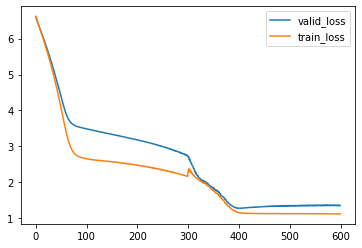

train_loss: 1.56297 | train_metric: -1.56297
valid_loss: 1.27585 | valid_metric: -1.27585
test_loss:  1.29161 | test_metric:  -1.29161
CPU times: user 1min 42s, sys: 1.53 s, total: 1min 44s
Wall time: 1min 45s


In [15]:
%%time

EMBEDDING_DIM = 50
LEARNING_RATE = 0.25 #1e-4
REGULARIZATION = 1e-6
BATCH_SIZE = 1024  # 64
EPOCH = 1200
TRIAL = 200

br = BetaRecommendation(field_dims, EMBEDDING_DIM).to(device)

optimizer = optim.Adam(br.parameters(), lr=LEARNING_RATE, weight_decay=REGULARIZATION)
scheduler = ConstantLR(optimizer, factor=0.2, total_iters=300)
# criterion = nn.BCELoss()
# criterion = nn.CrossEntropyLoss()
criterion = Beta_Loss(model=br)

trainer = Trainer(br, optimizer, criterion, BATCH_SIZE, scheduler=scheduler, task=task)
trainer.train(train_X, train_y, epoch=EPOCH, trials=TRIAL, valid_X=valid_X, valid_y=valid_y)
test_loss, test_metric = trainer.test(test_X, test_y)
print('test_loss:  {:.5f} | test_metric:  {:.5f}'.format(test_loss, test_metric))

Train loss: 1.120 | Validation loss 1.353:  49%|████▉     | 585/1200 [01:08<01:12,  8.48it/s]


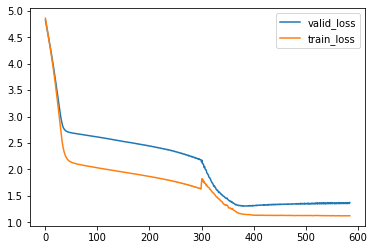

train_loss: 1.56755 | train_metric: -1.56755
valid_loss: 1.30455 | valid_metric: -1.30455
test_loss:  1.31587 | test_metric:  -1.31587
CPU times: user 1min 7s, sys: 1.43 s, total: 1min 8s
Wall time: 1min 9s


In [16]:
%%time


br = BetaRecommendation(field_dims, 25).to(device)

optimizer = optim.Adam(br.parameters(), lr=LEARNING_RATE, weight_decay=REGULARIZATION)
scheduler = ConstantLR(optimizer, factor=0.2, total_iters=300)

criterion = Beta_Loss(model=br)

trainer = Trainer(br, optimizer, criterion, BATCH_SIZE, scheduler=scheduler, task=task)
trainer.train(train_X, train_y, epoch=EPOCH, trials=TRIAL, valid_X=valid_X, valid_y=valid_y)
test_loss, test_metric = trainer.test(test_X, test_y)
print('test_loss:  {:.5f} | test_metric:  {:.5f}'.format(test_loss, test_metric))

Train loss: 1.112 | Validation loss 1.368:  48%|████▊     | 572/1200 [00:44<00:48, 12.97it/s]


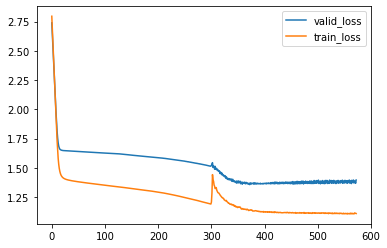

train_loss: 1.58820 | train_metric: -1.58820
valid_loss: 1.35632 | valid_metric: -1.35632
test_loss:  1.35850 | test_metric:  -1.35850
CPU times: user 42.8 s, sys: 1.21 s, total: 44 s
Wall time: 44.4 s


In [23]:
%%time


br = BetaRecommendation(field_dims, 5).to(device)

optimizer = optim.Adam(br.parameters(), lr=LEARNING_RATE, weight_decay=REGULARIZATION)
scheduler = ConstantLR(optimizer, factor=0.2, total_iters=300)

criterion = Beta_Loss(model=br)

trainer = Trainer(br, optimizer, criterion, BATCH_SIZE, scheduler=scheduler, task=task)
trainer.train(train_X, train_y, epoch=EPOCH, trials=TRIAL, valid_X=valid_X, valid_y=valid_y)
test_loss, test_metric = trainer.test(test_X, test_y)
print('test_loss:  {:.5f} | test_metric:  {:.5f}'.format(test_loss, test_metric))